# Which Whiskey Kaggle Challenge

## Imports

In [16]:
import pandas as pd
import zipfile
import numpy as np
import gensim
import os
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from scipy.stats import randint, uniform

import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter
import squarify
import warnings
import pyLDAvis.gensim

## Create Dataframe

In [17]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv')

In [18]:
train.head()

,id,description,category
0,1,A marriage of 13 and 18 year old bourbons. A m...,2
1,2,There have been some legendary Bowmores from t...,1
2,3,This bottling celebrates master distiller Park...,2
3,4,What impresses me most is how this whisky evol...,1
4,9,"A caramel-laden fruit bouquet, followed by une...",2


## Clean Dataframe

### Load Functions

In [19]:
nlp = spacy.load("en_core_web_lg")

def clean_soup(df_column, spec_chars_remove = []):  
    """
    Input: dataframe column and list of specific characters to remove, 
    
    Output: List of cleaned observations
    """
    
    soupy = [BeautifulSoup(df_column[ii], 'lxml').get_text() 
             for ii in range(df_column.shape[0])]
    
    for char in spec_chars_remove:
        soupy = [soupy[ii].replace(char, ' ') for ii in range(len(soupy))]
        
    to_clean = ['[^A-Za-z ]+', '   ', '  ']
    
    for char in to_clean:
        soupy = [re.sub(char, ' ', soupy[ii]) for ii in range(len(soupy))]
        
    df_feature = pd.Series([nlp(soupy[ii].lower().strip()) for ii in range(len(soupy))])
        
    for row in range(df_feature.shape[0]):
        df_feature[row] = " ".join([token.lemma_ for token in df_feature[row]])
         
    return df_feature

In [20]:
def make_tokens(df_feature, addl_stop_words = ['-PRON-']):
    """
    Input: Column of a dataframe/ Pandas Series, 
    stop words you'd like to add to nlp's defaults
    
    Output: List consisting of tokens for each observation
    
    Assumes: nlp object initialized as nlp
    """
    
    tokens = []
    tokenizer = Tokenizer(nlp.vocab)

    STOP_WORDS = nlp.Defaults.stop_words.union(addl_stop_words)

    for doc in tokenizer.pipe(df_feature, batch_size=500):

        doc_tokens = []

        for token in doc: 
            if token.text not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)

    return tokens

In [21]:
def whiskey_wrangle(df, stop_words = [], spec_chars = []):
    
    df = df.copy()
    
    df['description_redo'] = clean_soup(df['description'], spec_chars)
    df['description_tokens'] = make_tokens(df['description_redo'], stop_words)
    
    df['description_processed'] = df['description_tokens'].copy()
     
    for row in range(df['description_tokens'].shape[0]):
        df['description_processed'][row] = " ".join(df['description_tokens'][row])
    
    df.drop(columns = ['description'])
    
    return df

In [22]:
def count(docs):
    """
    Input: Series of spacy docs objects / dataframe column
    
    Output: Pandas dataframe consisting of words and their 
    stats based on how many times they appear in the series
    """
    word_counts = Counter()
    appears_in = Counter()
       
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
        
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
    return wc.sort_values(by='rank')

### Tune dataframe

In [40]:
stop_words = ['-PRON-', 'pron', 's', 't', 'whiskey', 
              'whisky', 'bottle', 'year', 'hint', 'note', 'finish',
             'palate', 'nose', 'like', 'good', 'new', 'aroma', 
              'slightly', 'release', 'long', 'subtle', 'balance',
             'rich', 'age', 'single', 'fruit', 'add', 'light', 
             'clean', 'distillery', 'flavor', 'cask', 'wood',
             'sorft','water', 'time', 'distil', 'bit', 'bottling',
             'old', 'young', 'fresh', 'hot', 'soft', 'mature',
             'complex','']

train_wrangled = whiskey_wrangle(train, stop_words)

test_wrangled = whiskey_wrangle(test, stop_words)

In [70]:
wc_cat_1 = count(train_wrangled[train_wrangled['category']==1]['description_tokens'])
wc_cat_2 = count(train_wrangled[train_wrangled['category']==2]['description_tokens'])
wc_cat_3 = count(train_wrangled[train_wrangled['category']==3]['description_tokens'])
wc_cat_4 = count(train_wrangled[train_wrangled['category']==4]['description_tokens'])

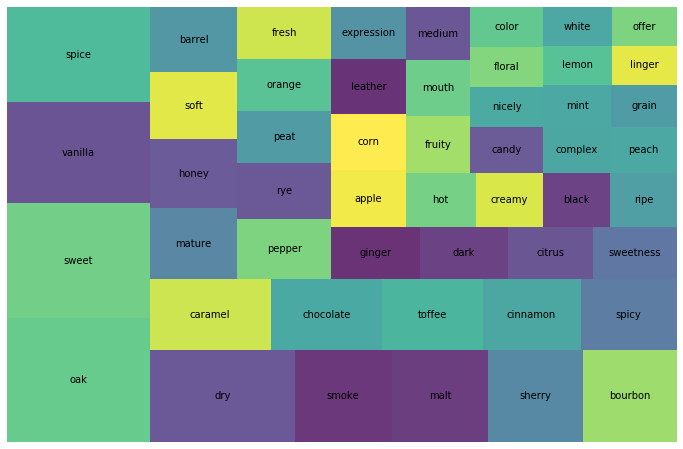

In [41]:
wc = count(train_wrangled['description_tokens'])

wc_top50 = wc[wc['rank'] <= 50] #explore what the top words are and help find additional stop_words

plt.rcParams['figure.figsize'] = (12,8)
squarify.plot(sizes=wc_top50['pct_total'], label=wc_top50['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [71]:
wc_cat_1

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
34,oak,560,726,1.0,0.013570,0.013570,0.342089
119,vanilla,618,674,2.0,0.012598,0.026168,0.377520
194,sweet,556,655,3.0,0.012243,0.038411,0.339646
17,dry,511,643,4.0,0.012019,0.050430,0.312156
216,sherry,407,636,5.0,0.011888,0.062318,0.248626
25,smoke,410,593,6.0,0.011084,0.073402,0.250458
114,spice,492,572,7.0,0.010692,0.084093,0.300550
587,malt,424,512,8.0,0.009570,0.093664,0.259010
70,chocolate,403,471,9.0,0.008804,0.102467,0.246182
101,mature,391,406,10.0,0.007589,0.110056,0.238852


In [43]:
X_train, X_val, y_train, y_val = train_test_split(train_wrangled['description_processed'], train_wrangled['category'],
                                                  test_size=0.20, random_state=42, stratify = train_wrangled['category'])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2068,), (518,), (2068,), (518,))

In [44]:
vect = TfidfVectorizer(stop_words=stop_words)

rfc = RandomForestClassifier()

svd = TruncatedSVD(algorithm='randomized')

In [45]:
# pipline using latent semantic indexing

lsi = Pipeline([('vect', vect), 
                ('svd', svd)])

pipeline = Pipeline([('lsi', lsi),
                 ('clf', rfc)])

# The pipeline puts together a bunch fit then transform,fit then predict.
parameters = {
    'lsi__vect__ngram_range': [(1,1),(1,2),(1,3)],
    'lsi__vect__max_df': uniform( 0.5, 1.0),
    'lsi__vect__min_df': uniform(.01, .05),
    'lsi__vect__max_features': randint(500,10000),
    'lsi__svd__n_components': randint(5, 90),
    'clf__n_estimators': randint(50, 500),
    'clf__max_depth': [5, 10, 20, 40, None],
    'clf__min_samples_leaf': randint(5,50),
    'clf__max_features': uniform(0, 1),
    'clf__class_weight':['balanced','balanced_subsample',None] 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=parameters, 
    n_iter=30, 
    cv=5, 
    return_train_score=True,
    verbose = 10,
    n_jobs = -1
)
search.fit(X_train, y_train)

print(f'Best score: {search.best_score_}\n')
print(f'Best hyperparameters: \n{search.best_params_}\n')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.2min finished


Best score: 0.8578336557059961

Best hyperparameters: 
{'clf__class_weight': 'balanced', 'clf__max_depth': 40, 'clf__max_features': 0.06198493049755738, 'clf__min_samples_leaf': 29, 'clf__n_estimators': 395, 'lsi__svd__n_components': 45, 'lsi__vect__max_df': 0.9541204369001214, 'lsi__vect__max_features': 2351, 'lsi__vect__min_df': 0.01863455471487111, 'lsi__vect__ngram_range': (1, 2)}



In [46]:
best_pipeline = search.best_estimator_
best_pipeline.fit(X_train, y_train)

print(f'Validation Accuracy: \n{best_pipeline.score(X_val, y_val)}\n')

Validation Accuracy: 
0.8571428571428571



In [30]:
len(best_pipeline.steps[0][1].steps[0][1].get_feature_names())

330

In [58]:
X_test = test_wrangled['description_processed']

In [59]:
test_pred = best_pipeline.predict(X_test)

In [62]:
submission = pd.DataFrame({'id': test_wrangled['id'], 'category':test_pred})
submission['category'] = submission['category'].astype('int64')
submission.head()

,id,category
0,955,2
1,3532,2
2,1390,1
3,1024,1
4,1902,1


In [65]:
submission.to_csv(f'submission_1.csv', index=False)